In [1]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from client import client
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

# moves your model to train on your gpu if available else it uses your cpu
device = ("cuda" if torch.cuda.is_available() else "cpu")
cli=client()

connection id  0


In [2]:
# Define transform to normalize data
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))
                                ])



# Download and load the training data
dataset1 = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)
# dataset2 = datasets.MNIST('DATA_MNIST/', download=True, train=True, transform=transform)

d1=dataset1.targets<5
dataset1.data=dataset1.data[d1]
dataset1.targets=dataset1.targets[d1]
# d1=dataset2.targets>=5
# dataset2.data=dataset2.data[d1]
# dataset2.targets=dataset2.targets[d1]
print("dataset 1 labels",torch.unique(dataset1.targets))
# print("dataset 2 labels",torch.unique(dataset2.targets))
trainloader1 = torch.utils.data.DataLoader(dataset1, batch_size=64, shuffle=True)
# trainloader2 = torch.utils.data.DataLoader(dataset2, batch_size=64, shuffle=True)

test_set = datasets.MNIST('DATA_MNIST/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=True)

dataset 1 labels tensor([0, 1, 2, 3, 4])


In [3]:
training_data = enumerate(trainloader1)
batch_idx, (images, labels) = next(training_data)
print(type(images)) # Checking the datatype 
print(images.shape) # the size of the image
print(labels.shape) # the size of the labels

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


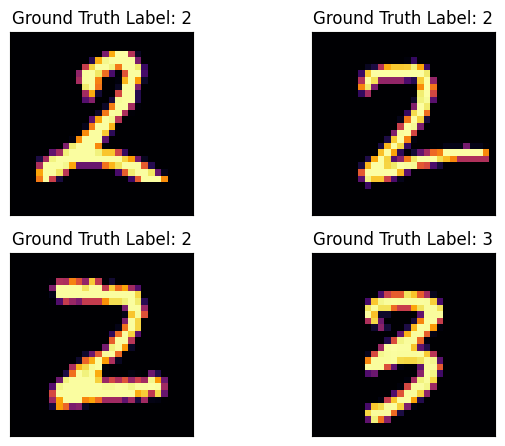

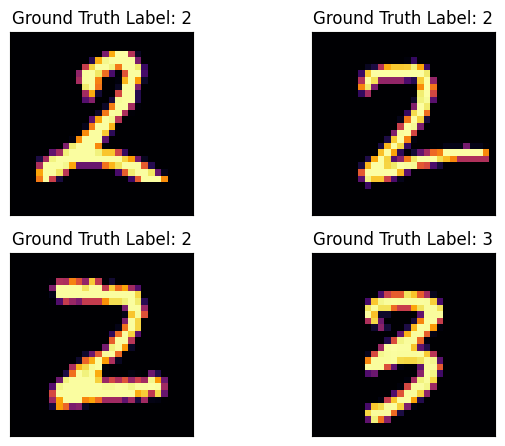

In [4]:
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(images[i][0], cmap='inferno')
    plt.title("Ground Truth Label: {}".format(labels[i]))
    plt.yticks([])
    plt.xticks([])
fig

In [5]:
class Network(nn.Module):

    def __init__(self):
        super(Network, self).__init__()
        # Convolutional Neural Network Layer 
        self.convolutaional_neural_network_layers = nn.Sequential(
                # Here we are defining our 2D convolutional layers
                # We can calculate the output size of each convolutional layer using the following formular
                # outputOfEachConvLayer = [(in_channel + 2*padding - kernel_size) / stride] + 1
                # We have in_channels=1 because our input is a grayscale image
                nn.Conv2d(in_channels=1, out_channels=12, kernel_size=3, padding=1, stride=1), # (N, 1, 28, 28) 
                nn.ReLU(),
                # After the first convolutional layer the output of this layer is:
                # [(28 + 2*1 - 3)/1] + 1 = 28. 
                nn.MaxPool2d(kernel_size=2), 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 28 / 2 = 14
          
                # output of our second conv layer
                nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, padding=1, stride=1),
                nn.ReLU(),
                # After the second convolutional layer the output of this layer is:
                # [(14 + 2*1 - 3)/1] + 1 = 14. 
                nn.MaxPool2d(kernel_size=2) 
                # Since we applied maxpooling with kernel_size=2 we have to divide by 2, so we get
                # 14 / 2 = 7
        )

        # Linear layer
        self.linear_layers = nn.Sequential(
                # We have the output_channel=24 of our second conv layer, and 7*7 is derived by the formular 
                # which is the output of each convolutional layer
                nn.Linear(in_features=24*7*7, out_features=64),          
                nn.ReLU(),
                nn.Dropout(p=0.2), # Dropout with probability of 0.2 to avoid overfitting
                nn.Linear(in_features=64, out_features=10) # The output is 10 which should match the size of our class
        )

    # Defining the forward pass 
    def forward(self, x):
        x = self.convolutaional_neural_network_layers(x)
        # After we get the output of our convolutional layer we must flatten it or rearrange the output into a vector
        x = x.view(x.size(0), -1)
        # Then pass it through the linear layer
        x = self.linear_layers(x)
        # The softmax function returns the prob likelihood of getting the input image. 
        # We will see a much graphical demonstration below
        x = F.log_softmax(x, dim=1)
        return x

In [6]:
model1 = Network()
model1.to(device)
print(model1)

Network(
  (convolutaional_neural_network_layers): Sequential(
    (0): Conv2d(1, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=1176, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=10, bias=True)
  )
)


In [7]:
optimizer1 = optim.Adam(model1.parameters(), lr=0.01)
# optimizer2 = optim.Adam(model2.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()

In [8]:
epochs = 3 # The total number of iterations

train_losses = []
test_losses = []
brake=False
for epoch in range(epochs):
    # prep model for training
    model1.train()
    # model2.train()
    train_loss = 0
    # tr2=iter(trainloader2)
    for idx, (images1, labels1) in enumerate(trainloader1): 
        # images2,labels2=next(tr2)
        # if labels2.shape!=labels1.shape:
            # break

        images1 = images1.to(device)
        labels1 = labels1.to(device)
        # images2 = images2.to(device)
        # labels2 = labels2.to(device)

        # Training pass
        optimizer1.zero_grad()
        # optimizer2.zero_grad()

        # Forward pass
        output1 = model1(images1)
        loss1 = criterion(output1, labels1)
        # output2 = model2(images2)
        # loss2 = criterion(output2, labels2)
        
        #Backward pass
        # loss2.backward()
        # optimizer2.step()
        loss1.backward()
        optimizer1.step()
        
        ######################################################################
        ######################### averging all weights ########################

        # state1=model1.state_dict()
        # state2=model2.state_dict()
        # for key in model1.state_dict():
            # state1[key]=(model1.state_dict()[key]+model2.state_dict()[key])/2.0
        if not cli.merge(model1):
            brake=True
            break
        # model1.load_state_dict(state1)
        # model2.load_state_dict(state1)
        
        ########################################################################
        ########################################################################
        train_loss += loss1.item()
        # train_loss += loss2.item()
    
    
    # prep model for evaluation
    model1.eval() 
    test_loss = 0
    accuracy = 0

    # Turn off the gradients when performing validation.
    # If we don't turn it off, we will comprise our networks weight entirely
    with torch.no_grad():
        for images, labels in testloader:

            images = images.to(device)
            labels = labels.to(device)

            log_probabilities = model1(images)
            test_loss += criterion(log_probabilities, labels)

            probabilities = torch.exp(log_probabilities)
            top_prob, top_class = probabilities.topk(1, dim=1)
            predictions = top_class == labels.view(*top_class.shape)
            accuracy += torch.mean(predictions.type(torch.FloatTensor))

    train_losses.append(train_loss/len(trainloader1))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}  ".format(epoch+1, epochs),
          "Training loss: {:.4f}  ".format(train_loss/len(trainloader1)),
          "Testing loss: {:.4f}  ".format(test_loss/len(testloader)),
          "Test accuracy: {:.4f}  ".format(accuracy/len(testloader)))
    if brake:
        break
del cli

Epoch: 1/3   Training loss: 0.2172   Testing loss: 0.0790   Test accuracy: 0.9744  
Epoch: 2/3   Training loss: 0.0781   Testing loss: 0.0504   Test accuracy: 0.9845  
Epoch: 3/3   Training loss: 0.0537   Testing loss: 0.0698   Test accuracy: 0.9779  
closing initiated


torch.Size([1, 1, 28, 28])
################### MODEL 1 ####################
[8.9835626e-04 9.8655313e-01 2.0903659e-04 2.6729048e-04 7.9903298e-04
 3.6916317e-04 2.2633059e-03 6.3308820e-05 8.3796456e-03 1.9775491e-04]


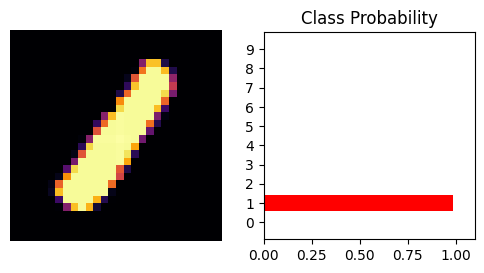

In [9]:
img = images[11]
img = img.to(device)
img = img.view(-1, 1, 28, 28)
print(img.shape)

# Since we want to use the already pretrained weights to make some prediction
# we are turning off the gradients
model1.eval()
# model2.eval()
print("################### MODEL 1 ####################")
with torch.no_grad():
    logits = model1.forward(img)

probabilities = F.softmax(logits, dim=1).detach().cpu().numpy().squeeze()

print(probabilities)

fig, (ax1, ax2) = plt.subplots(figsize=(6,8), ncols=2)
ax1.imshow(img.view(1, 28, 28).detach().cpu().numpy().squeeze(), cmap='inferno')
ax1.axis('off')
ax2.barh(np.arange(10), probabilities, color='r' )
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(10))
ax2.set_yticklabels(np.arange(10))
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.show()

